In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

AU_TO_EV = 27.2113961317875

In [2]:
# зависимость импульса от координаты
def p(x, z, a, kappa):
    return np.sqrt(2*z/np.sqrt(x**2+a**2)-kappa**2)

# точка поворота
def get_x0(z, a, kappa):
    Ip = kappa**2 / 2
    return np.sqrt(z**2/Ip**2 - a**2)

In [3]:
# рассмотрим s-аргон Ar18:
z = 18
a = 0.07773
Ip = 162.66
sigma = 99.0662
kappa = np.sqrt(2*Ip)
x0 = get_x0(z, a, kappa)

# 1 способ

In [4]:
# вычисляем int_0^x0 1/p dx
integral = sp.integrate.quad(lambda x: 1/p(x, z, a, kappa), -x0, x0)
integral_in_cos = lambda x: sp.integrate.quad(lambda t: p(t, z, a, kappa) , x, x0)[0]
integral_accurate = sp.integrate.quad(lambda x: 1/p(x, z, a, kappa) * np.cos(integral_in_cos(x) - np.pi/4)**2, -x0, x0)

# нормировочный коэффициент
C1 = np.sqrt(2/integral[0])
C1_accurate = np.sqrt(2/integral_accurate[0])
print("Нормировочный коэффициент C1          = ", C1)
print("Нормировочный коэффициент C1_accurate = ", C1_accurate)

Нормировочный коэффициент C1          =  9.069007712633319
Нормировочный коэффициент C1_accurate =  10.549167538487941


# 2 способ

In [5]:
# вычисляем интеграл int_0^x0 p dx
integral_pdx = sp.integrate.quad(lambda x: p(x, z, a, kappa), 0, x0)
print("integral_pdx = ", integral_pdx)

# нормировочный коэффициент
C2 = (sigma/np.pi)**(1/4) * np.sqrt(p(0, z, a, kappa)) / np.cos(integral_pdx[0]-np.pi/4)
print("Нормировочный коэффициент C2 = ", C2)

integral_pdx =  (0.6752016915139243, 3.267408565932328e-11)
Нормировочный коэффициент C2 =  8.168936019296746


Слегка не совпадают. Сравним волновые функции.

# Сравним волновые функции

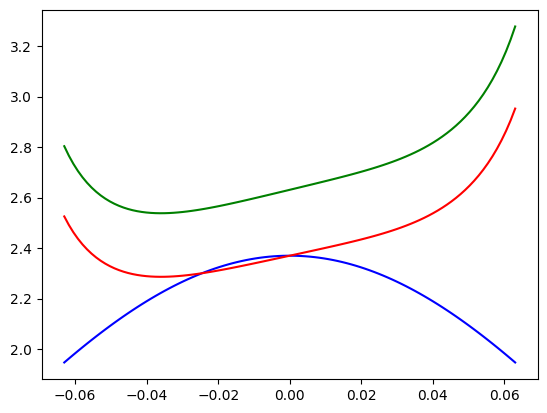

In [6]:
# фитированная волновая функция
def psi0(x, sigma):
    return (sigma/np.pi)**(1/4) * np.exp(-sigma*x**2 / 2)

# ВКБ волновая функция
def psi_VKB(x, C, z, a, kappa, x0):
    integral_pdx = sp.integrate.quad(lambda x: p(x, z, a, kappa), -x0, x)
    return C/np.sqrt(p(x, z, a, kappa)) * np.cos(integral_pdx[0] - np.pi/4)
psi_VKB = np.vectorize(psi_VKB)

x = np.linspace(-0.8*x0, 0.8*x0, 100)
plt.plot(x, psi0(x, sigma), color="blue")
plt.plot(x, psi_VKB(x, C1, z, a, kappa, x0), color="green")
plt.plot(x, psi_VKB(x, C2, z, a, kappa, x0), color="red");

Дичь какая-то...

# Разбираемся

In [7]:
# потенциал
def V(x, z, a):
    return -z/np.sqrt(x**2+a**2)

## Поучительные картинки

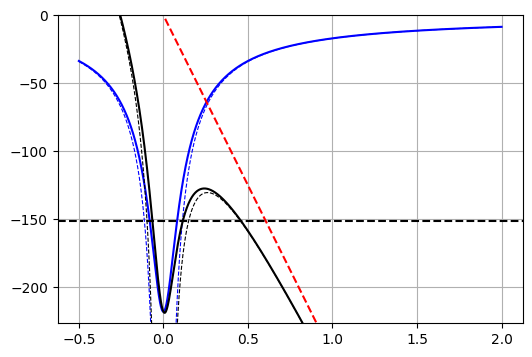

In [10]:
# Ar18
z = 17; a = 0.078; Ip = 151; E = 250
x = np.linspace(-0.5, 2, 1000)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.set(ylim=[-1.5*Ip, 0])
ax.plot(x, V(x, z, 0), "--b", linewidth = 0.8)
ax.plot(x, V(x, z, a), "-b")
ax.plot(x, -E*x, "--r")
ax.plot(x, V(x, z, 0) - E*x, color="black", linestyle = "--", linewidth = 0.8)
ax.plot(x, V(x, z, a) - E*x, color="black", linestyle = "-")
ax.axhline(-Ip, color="black", linestyle="--"); ax.grid();

**Выводы для Ar18:**
1) Большой сглаживающий параметр $a$ **дает** сдвиг точки входа
2) Сглаживающий параметр $a$ **слабо влияет** на точку выхода
3) Для сильных полей точка выхода из под барьера значительно отличается от $E/I_p$

## Квазиклассическая в.ф. под барьером

In [10]:
# точка входа
def get_x_in(z, a, kappa):
    Ip = kappa**2 / 2
    return np.sqrt(z**2/Ip**2 - a**2)

def get_x_in_accurate(z, a, kappa, E):
    x0 = get_x_in(z, a, kappa)
    x = sp.optimize.root_scalar(lambda x: 2*z/np.sqrt(x**2+a**2) + 2*E*x - kappa**2, x0 = x0)["root"]
    return x

def p_abs(x, z, a, kappa, E):
    return np.sqrt(kappa**2 - 2*z/np.sqrt(x**2+a**2) - 2*E*x)
    
def psi_semiclassic_ub(x, C, z, a, kappa, E):
    p = lambda x: p_abs(x, z, a, kappa, E)
    x_in = get_x_in_accurate(z, a, kappa, E)
    integral = sp.integrate.quad(p, x_in, x)[0]
    return C/np.sqrt(p(x)) * np.exp(-integral)
    
psi_semiclassic_ub = np.vectorize(psi_semiclassic_ub)

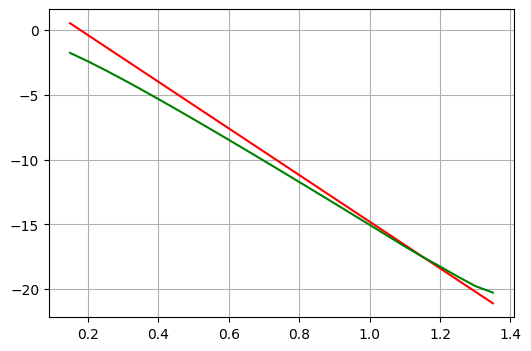

In [60]:
# Ar18
z = 18; a = 0.078; Ip = 162; E = 100
kappa = np.sqrt(2*Ip)
x_in = get_x_in_accurate(z, a, kappa, E)
# x = np.linspace(0.6, 1.45, 1000)
x = np.load("/home/denis/RustSSFM/RSSFM2D/src/out/dim1/x0.npy")
psi_initial = np.load("/home/denis/RustSSFM/RSSFM2D/src/out/dim1/psi_initial.npy")

mask = x>0.1
x = x[mask]
psi_initial = psi_initial[mask]
mask = x<1.4
x = x[mask]
psi_initial = psi_initial[mask]

# затравочная волновая функция основного состояния
def psi0(x, sigma):
    return (sigma/np.pi)**(1/4) * np.exp(-sigma*x**2 / 2)
# асимптотический хвост
def psi_asymp(x, C, kappa):
    return C*np.exp(-kappa*x)

sigma = 99.0662

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
# ax.plot(x, psi_semiclassic_ub(x, 1, z, a, kappa, E))
ax.plot(x, np.log(psi_asymp(x, 25, kappa)), color="red")
ax.plot(x, np.log(psi_initial), color="green")
ax.grid();

In [45]:
# затравочная волновая функция основного состояния
def psi0(x, b):
    return (b/np.pi)**(1/4) * np.exp(-b*x**2 / 2)

In [46]:
# энергия основного состояния
def K0(x):
    return sp.special.kn(0, x)
    
def K1(x):
    return sp.special.kn(1, x)
    
def E0(b, k, d):
    return b/4 - k*np.sqrt(b/np.pi)*np.exp(d**2*b/2) * K0(d**2*b/2)

In [47]:
# уравнение, минимизирующее энергию (далее не используется)
def dE0_db(b, k, d):
    t = d**2 * b
    a = 1/k
    return np.exp(t/2)/np.sqrt(t) * (
        (1+t)*K0(t/2) - t*K1(t/2)
    ) - np.sqrt(np.pi)/2 * a/d

In [48]:
# минимизация энергии
def energy_minimization(k, d):
    minimization_results = sp.optimize.minimize(lambda b: E0(b, k, d), x0=1)
    E_min = minimization_results["fun"]
    b_min = minimization_results["x"][0]
    return b_min, E_min

In [49]:
# подбор параметра d для заданной энергии
# dmin, dmax -- диапазон d
def fit_d(E0, k, dmin, dmax):
    delta_energy = lambda d: energy_minimization(k, d)[1] - E0
    return sp.optimize.bisect(delta_energy, dmin, dmax)

## Ar18 основное состояние

In [59]:
# рассмотрим Ar18
k = 18
d_fitted = fit_d(-162.6608564501, k, 0.001, 0.1)
b_min, E_min = energy_minimization(k, d_fitted)
print("d_fitted = ", d_fitted)
print("b_min    = ", b_min)
print("E_min    = ", E_min, "au = ", E_min*AU_TO_EV, "eV")

d_fitted =  0.07773024924787751
b_min    =  99.06619189087772
E_min    =  -162.66085645276254 au =  -4426.229000071944 eV


Получаем, что волновая функция основного состояния Ar18:
$$
\psi_0(x) = \left(\dfrac{b}{\pi}\right)^{1/4}\exp\left(-\dfrac{b x^2}{2}\right)
$$
где $b=99.06619189087772$

In [60]:
# протестируем мои параметры из SSFM расчета
k = 18
d = 0.07818

b_min, E_min = energy_minimization(k, d)
print("d     = ", d)
print("b_min = ", b_min)
print("E_min = ", E_min)

d     =  0.07818
b_min =  98.36704765237765
E_min =  -161.86708013130024


Хорошо сходятся!